# Loan Default Prediction
## Team Members:
* Harish Puvvada
* Vamsi Mohan Ramineedi

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing,metrics 
from IPython.core.display import HTML
pd.set_option("display.max_columns",75)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

In [2]:
df2012_13 = pd.read_csv(os.getenv('FDS')+'LoanStats_2012_to_2013.csv',low_memory=False,skiprows=1)
df2014 = pd.read_csv(os.getenv('FDS')+'LoanStats_2014.csv',low_memory=False,skiprows=1)

## Data Cleaning

In [3]:
dataset = pd.concat([df2012_13, df2014]) #merging 2007 to 2014 datasets
dataset = dataset.iloc[:,2:111]          #removing empty columns
empty_cols = [i for i in range(45,72)]   #more empty columns
dataset = dataset.drop(dataset.columns[empty_cols],axis=1)
data_with_loanstatus_sliced = dataset[(dataset['loan_status']=="Fully Paid") | (dataset['loan_status']=="Charged Off")]
di = {"Fully Paid":0, "Charged Off":1}   #converting target variable to boolean
Dataset_withBoolTarget= data_with_loanstatus_sliced.replace({"loan_status": di})

In [4]:
Dataset_withBoolTarget['loan_status'].value_counts()
print("Current shape of dataset :",Dataset_withBoolTarget.shape)
Dataset_withBoolTarget.head(3)

Current shape of dataset : (376233, 82)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,27050.0,27050.0,27050.0,36 months,10.99%,885.46,B,B2,Team Leadern Customer Ops & Systems,10+ years,OWN,55000.0,Verified,Dec-2013,0,n,NaN,Borrower added on 12/31/13 > Combining high ...,debt_consolidation,Debt Consolidation,481xx,MI,22.87,0.0,Oct-1986,0.0,NaN,NaN,14.0,0.0,36638.0,61.2%,27.0,w,0.0,0.0,31752.530000,...,3.0,9570.0,16473.0,53.9,0.0,0.0,117.0,326.0,16.0,6.0,4.0,16.0,NaN,8.0,NaN,0.0,2.0,4.0,4.0,8.0,8.0,10.0,15.0,4.0,14.0,0.0,0.0,0.0,1.0,100.0,25.0,0.0,0.0,138554.0,70186.0,35700.0,33054.0
1,12000.0,12000.0,12000.0,36 months,10.99%,392.81,B,B2,Project Manager,4 years,RENT,60000.0,Not Verified,Dec-2013,0,n,NaN,Borrower added on 12/31/13 > I would like to...,debt_consolidation,No Regrets,281xx,NC,4.62,0.0,Dec-2009,1.0,NaN,NaN,15.0,0.0,7137.0,24%,18.0,f,0.0,0.0,13988.609996,...,8.0,476.0,15216.0,15.9,0.0,0.0,NaN,48.0,1.0,1.0,0.0,1.0,NaN,3.0,NaN,0.0,4.0,7.0,8.0,10.0,0.0,15.0,18.0,7.0,15.0,0.0,0.0,0.0,4.0,100.0,0.0,0.0,0.0,29700.0,7137.0,18100.0,0.0
2,4800.0,4800.0,4800.0,36 months,10.99%,157.13,B,B2,Surgical Technician,2 years,MORTGAGE,39600.0,Source Verified,Dec-2013,0,n,NaN,Borrower added on 12/31/13 > Just bought a h...,home_improvement,For The House,782xx,TX,2.49,0.0,Aug-1995,2.0,NaN,NaN,3.0,0.0,4136.0,16.1%,8.0,w,0.0,0.0,5157.519457,...,0.0,1379.0,21564.0,16.1,0.0,0.0,104.0,220.0,25.0,25.0,0.0,25.0,NaN,3.0,NaN,0.0,2.0,2.0,3.0,4.0,1.0,3.0,7.0,2.0,3.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,25700.0,4136.0,25700.0,0.0


In [5]:
#print(Dataset_withBoolTarget.shape)
dataset=Dataset_withBoolTarget.dropna(thresh = 340000,axis=1) #340000 is minimum number of non-NA values
#print(x.isnull().sum()) #- to check how many null values in all the columns
print("Current shape of dataset :",dataset.shape)

Current shape of dataset : (376233, 74)


In [6]:
del_col_names = ["delinq_2yrs",  "last_pymnt_d", "chargeoff_within_12_mths","delinq_amnt","emp_title", "term", "emp_title", "pymnt_plan","purpose","title", "zip_code", "verification_status", "dti","earliest_cr_line", "initial_list_status", "out_prncp",
"pymnt_plan", "num_tl_90g_dpd_24m", "num_tl_30dpd", "num_tl_120dpd_2m", "num_accts_ever_120_pd", "delinq_amnt", 
"chargeoff_within_12_mths", "total_rec_late_fee", "out_prncp_inv", "issue_d"] #deleting some more columns
dataset = dataset.drop(labels = del_col_names, axis = 1) 
print("Current shape of dataset :",dataset.shape)

Current shape of dataset : (376233, 52)


In [7]:
features = ['funded_amnt','emp_length','annual_inc','home_ownership','grade',
                      'last_pymnt_amnt','mort_acc','int_rate','open_acc','loan_status']#'funded_amnt','emp_length','annual_inc','home_ownership','grade',
           # "last_pymnt_amnt", "mort_acc", "pub_rec", "int_rate", "open_acc","num_actv_rev_tl",
          #  "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy",
           # "avg_cur_bal","acc_open_past_24mths",'loan_status'] #selecting final features #'addr_state''tax_liens',
Final_data = dataset[features] #19 features with target var
Final_data["int_rate"] = Final_data["int_rate"].apply(lambda x:float(x[:-1]) ) #reomving % sign, conv to float  - int_rate column
Final_data= Final_data.reset_index(drop=True)
print("Current shape of dataset :",Final_data.shape)

Current shape of dataset : (376233, 10)


## Data Transformation


In [8]:
#Data encoding
Final_data['grade'] = Final_data['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})
Final_data["home_ownership"] = Final_data["home_ownership"].map({"MORTGAGE":6,"RENT":5,"OWN":4,"OTHER":3,"NONE":2,"ANY":1})
Final_data["emp_length"] = Final_data["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0'}, regex = True)
Final_data["emp_length"] = Final_data["emp_length"].apply(lambda x:int(x))
print("Current shape of dataset :",Final_data.shape)
Final_data.head()

Current shape of dataset : (376233, 10)


,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,int_rate,open_acc,loan_status
0,27050.0,10,55000.0,4,6,6074.19,4.0,10.99,14.0,0
1,12000.0,4,60000.0,5,6,3775.55,0.0,10.99,15.0,0
2,4800.0,2,39600.0,6,6,3900.48,0.0,10.99,3.0,0
3,12000.0,10,130000.0,6,6,398.28,3.0,11.99,9.0,0
4,7550.0,3,28000.0,5,5,529.67,0.0,16.24,4.0,0


In [9]:
#Final_data[Final_data['loan_status']==0]["last_pymnt_amnt"].value_counts()

## Filling Missing values and Feature scaling 


In [10]:
Final_data.fillna(Final_data.mean(),inplace = True)
HTML(Final_data.tail().to_html())
print("Current shape of dataset :",Final_data.shape)

Current shape of dataset : (376233, 10)


In [11]:
scl = preprocessing.StandardScaler() #instance of preprocessing
fields = Final_data.columns.values[:-1] 
data_clean = pd.DataFrame(scl.fit_transform(Final_data[fields]), columns = fields)
data_clean['loan_status'] = Final_data['loan_status']
data_clean['loan_status'].value_counts()

0    310035
1     66198
Name: loan_status, dtype: int64

In [12]:
loanstatus_0 = data_clean[data_clean["loan_status"]==0]
loanstatus_1 = data_clean[data_clean["loan_status"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=2500)
subset_of_loanstatus_1 = loanstatus_1.sample(n=2500)
data_clean = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
data_clean = data_clean.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",data_clean.shape)
data_clean.head()

Current shape of dataset : (5000, 10)


,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,int_rate,open_acc,loan_status
0,-0.994375,1.140751,-0.817156,-2.167321,0.591081,-0.699772,-0.376315,-0.304806,-1.271278,0
1,-0.323278,1.140751,-0.706111,0.899053,0.591081,-0.684295,-0.840272,-0.389420,-0.867998,0
2,-0.262269,-0.779355,-0.562474,-0.634134,0.591081,-0.682060,-0.840272,-0.304806,-1.271278,1
3,-0.506304,1.140751,1.476844,0.899053,1.362088,-0.166946,-0.376315,-1.418502,-0.666359,0
4,-1.336024,1.140751,-0.743126,0.899053,0.591081,-0.728880,-0.376315,-0.163021,1.148399,1


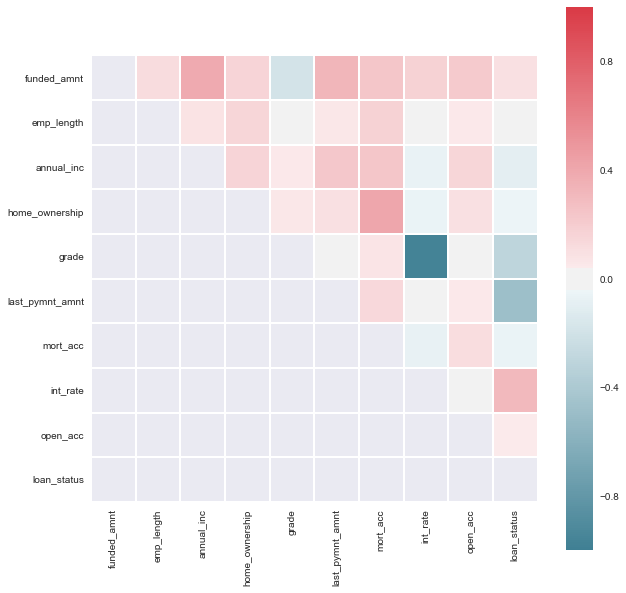

In [13]:
dataViz = data_clean[['funded_amnt','emp_length','annual_inc','home_ownership','grade',
                      'last_pymnt_amnt','mort_acc','int_rate','open_acc','loan_status']]

sns.set_context(context='notebook')
fig, ax = plt.subplots(figsize=(10,10)) 
corr = dataViz.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap,linewidths=1, vmin=-1, vmax=1, square=True, cbar=True, center=0, ax=ax, mask=mask)

## Learning Curve

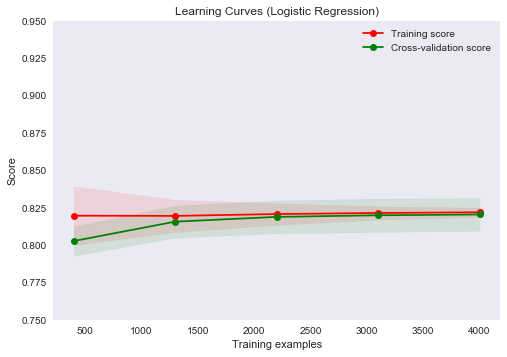

In [14]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


X, y = data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values

title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = linear_model.LogisticRegression()
plot_learning_curve(estimator, title, X, y, ylim=(0.75, 0.95), cv=cv, n_jobs=4)
plt.show()

## ROC Curve plot function

In [15]:
import seaborn as sns
sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")

## Confusion Matrix Viz function

In [16]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Algorithms


## Random Forest


In [17]:
X_train, X_test, y_train, y_test = train_test_split(data_clean.iloc[:,:-1], data_clean.iloc[:,-1], test_size=0.33, random_state=42)
bs_train, bs_test = train_test_split(data_clean, test_size = 0.33, random_state=42) #just for bootstrapping

In [18]:
randomForest = RandomForestClassifier(criterion = "gini")
randomForest.fit(X_train,y_train)
rfPredict = randomForest.predict(X_test)
rfAccuracy = accuracy_score(y_test,rfPredict)
roc_score = metrics.roc_auc_score(y_test,rfPredict)
print(rfAccuracy)

0.794545454545


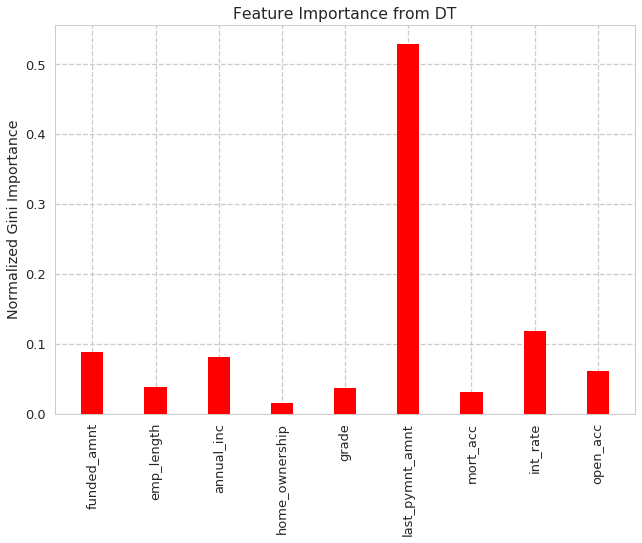

In [19]:
fig, ax = plt.subplots()
width=0.35
ax.bar(np.arange(len(fields)), randomForest.feature_importances_, width, color='r')
ax.set_xticks(np.arange(len(randomForest.feature_importances_)))
ax.set_xticklabels(X_train.columns.values,rotation=90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')

## ROC-AUC curve plot function


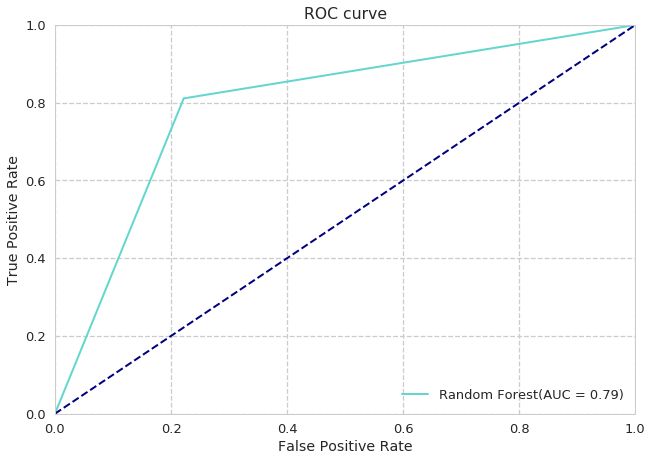

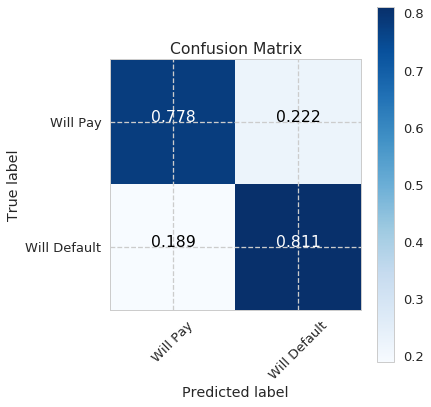

In [20]:
plotAUC(y_test,rfPredict, 'Random Forest')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(rfPredict, normalize=True)
plt.show()

## Logistic Regression


Logistic regression accuracy is  0.808484848485


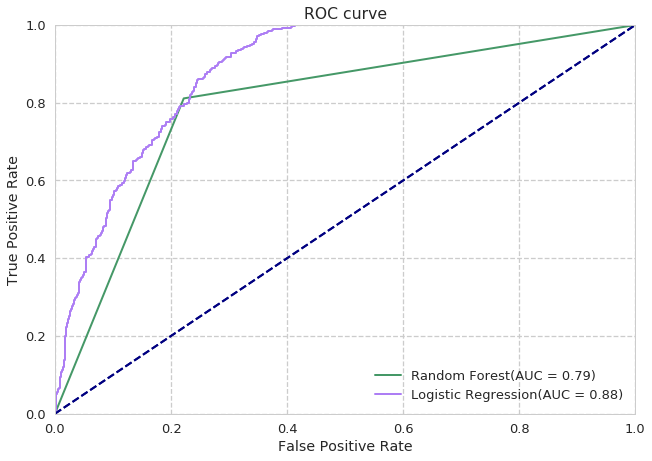

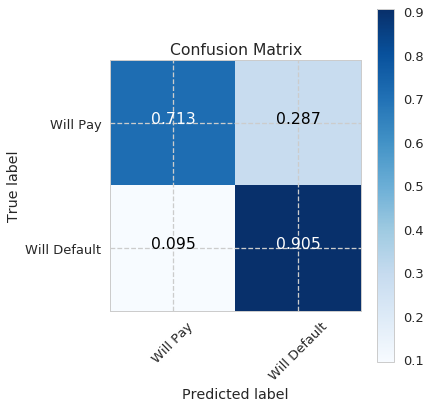

In [21]:
clf_LR = linear_model.LogisticRegression(C=1e30)
clf_LR.fit(X_train,y_train)
LR_Predict = clf_LR.predict_proba(X_test)[:,1]
LR_Predict_bin = clf_LR.predict(X_test)
LR_Accuracy = accuracy_score(y_test,LR_Predict.round())
print("Logistic regression accuracy is ",LR_Accuracy)
plotAUC(y_test,rfPredict, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(LR_Predict_bin, normalize=True)
plt.show()

## Support Vector Machines(SVM)


SVM accuracy is  0.80303030303


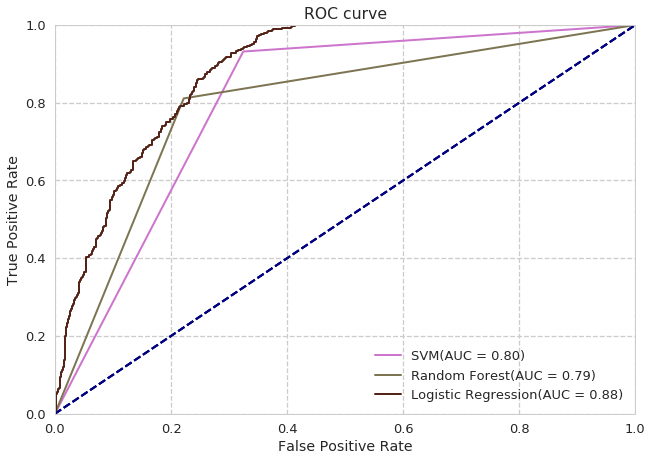

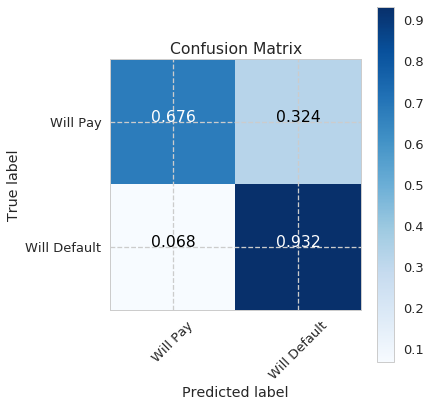

In [22]:
clf_svm = svm.SVC(kernel = "rbf")
clf_svm.fit(X_train.iloc[:,[0,4,5,8]],y_train)
predictions_svm = clf_svm.predict(X_test.iloc[:,[0,4,5,8]])
SVM_Accuracy = accuracy_score(y_test,predictions_svm)
print("SVM accuracy is ",SVM_Accuracy)
plotAUC(y_test,predictions_svm, 'SVM')
plotAUC(y_test,rfPredict, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(predictions_svm, normalize=True)
plt.show()

## K Nearest Neighbours(KNN) with Grid Search and cross validation

fitting done
[0.758, 0.7596, 0.759, 0.7608, 0.7586, 0.763, 0.7586, 0.7604, 0.7566, 0.7584, 0.756, 0.7582, 0.7562, 0.7584, 0.7544]
---------------
0.763
--------------
{'n_neighbors': 40}
---------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=40, p=2,
           weights='uniform')


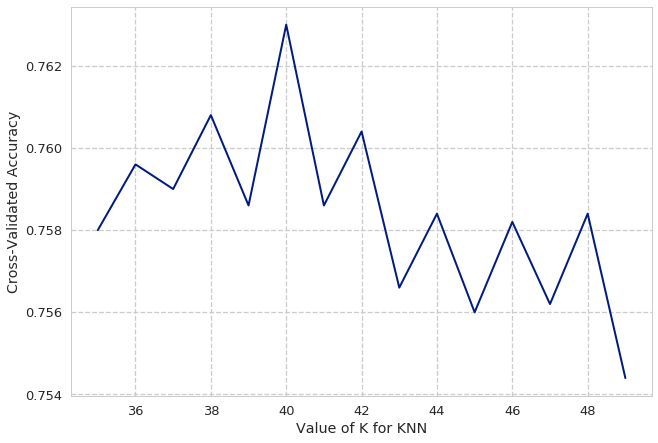

In [30]:
#KNN_Acc = knnfunc(2,10) - 74.8 max, 75.7 for 15, 25 - 76.2, 30 - 76.1
from sklearn.grid_search import GridSearchCV    ## takes too much time to run this cell.
clf_knn = KNeighborsClassifier()
k_range = list(range(35, 50))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(clf_knn, param_grid, cv=10, scoring='accuracy')
grid.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
print("fitting done")
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]# create a list of the mean scores only
print(grid_mean_scores)
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
print("---------------")
print(grid.best_score_)
print("--------------")
print(grid.best_params_)
print("---------------")
print(grid.best_estimator_)

In [39]:
print("",grid.best_params_['n_neighbors'])
clf_knn_final = KNeighborsClassifier(n_neighbors=grid.best_params_.items())   #taking the the best from the above cell and using it to find predictions
clf_knn_final.fit(X_train,y_train)
knn_pred = clf_knn_final.predict(X_test)
KNN_Acc = accuracy_score(y_test,knn_pred)
print("KNN accuracy is ",KNN_Acc)
plotAUC(y_test,rfPredict, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,predictions_svm, 'SVM')
plotAUC(y_test,knn_pred,'K Nearest Neighbors')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(knn_pred, normalize=True)
plt.show()

 40


TypeError: '<' not supported between instances of 'dict_items' and 'int'

## Bootstrapping to find errors

In [25]:
def modBootstrapper(train, test, nruns, sampsize, lr, c):
    target = 'loan_status'
    aucs_boot = []
    for i in range(nruns):
        train_samp = train.iloc[np.random.randint(0, len(train), size = sampsize)] #selecting random indexes for KFold
        if (lr == 1):
            lr_i = linear_model.LogisticRegression(C = 1e30)
            lr_i.fit(train_samp.drop(target,1), train_samp[target]) #Linear regression fitting and predicting if lr==1
            p = lr_i.predict_proba(test.drop(target,1))[:,1]
        else:
            svm_i = svm.SVC(kernel='rbf', C = c) #hardcoding the value since it is negative power error.
            svm_i.fit(train_samp.drop(target,1), train_samp[target])#SVM fitting and predicting if lr==0
            p = svm_i.decision_function(test.drop(target,1))
        
        aucs_boot.append(metrics.roc_auc_score(test[target], p)) #calculating auc scores for each bag in bootstrapping
    
    return [np.mean(aucs_boot), np.sqrt(np.var(aucs_boot))] #mean, standard error = square root of variance

250
1000
1500
2000
2500
3000
3750
4500
4750


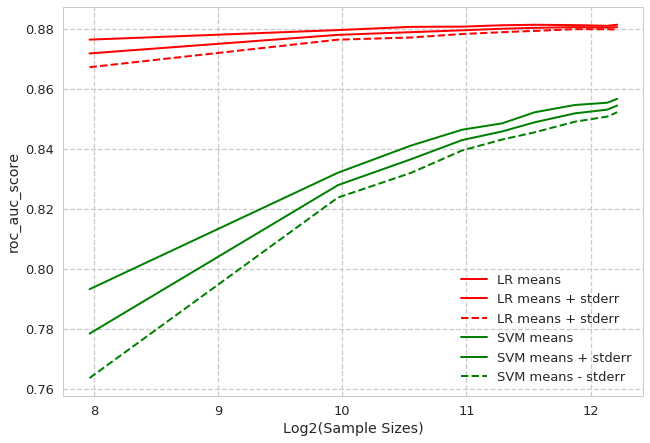

In [26]:
SampleSizes = [250, 1000,1500, 2000,2500,3000,3750,4500,4750] #various samples of dataset , 100000, 125000, 136000

LR_means = []
Lr_stderr = []
svm_means = []
svm_stderr = []
for n in SampleSizes:
    mean, err = modBootstrapper(bs_train, bs_test, 20, n, 1, 0.1)# collecting means and stderrs for LR model
    print(n)
    LR_means.append(mean)
    Lr_stderr.append(err)
    mean2, err2 = modBootstrapper(bs_train, bs_test, 20, n, 0, 0.1)# collecting means and stderrs for SVM model
    svm_means.append(mean2)
    svm_stderr.append(err2)
    
plt.plot(np.log2(SampleSizes), LR_means, 'r', label = 'LR means')
plt.plot(np.log2(SampleSizes), LR_means + np.array(Lr_stderr), 'r+-' , label = 'LR means + stderr')
plt.plot(np.log2(SampleSizes), LR_means - np.array(Lr_stderr), 'r--',  label = 'LR means + stderr')

plt.plot(np.log2(SampleSizes), svm_means, 'g', label = 'SVM means')
plt.plot(np.log2(SampleSizes), svm_means + np.array(svm_stderr), 'g+-', label = 'SVM means + stderr')
plt.plot(np.log2(SampleSizes), svm_means - np.array(svm_stderr), 'g--', label = 'SVM means - stderr')

plt.legend(loc = 'lower right')
plt.xlabel('Log2(Sample Sizes)')
plt.ylabel('roc_auc_score')

## Bagging for Classification

In [27]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
num_trees = 100
model = BaggingClassifier(base_estimator=randomForest, n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values, cv=kfold)
print(results.mean())

KeyboardInterrupt: 

## Ada Boost classifier

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
Ada_clf = AdaBoostClassifier(n_estimators=50)
scores = cross_val_score(Ada_clf, data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
scores.mean()

## Confusion Matrix plot

## Precision,recall,F1score for all algorithms

In [ ]:
from sklearn.metrics import classification_report
print("RF",classification_report(y_test, rfPredict, target_names=None))
print("SVM",classification_report(y_test, predictions_svm, target_names=None))
print("LR",classification_report(y_test, LR_Predict_bin, target_names=None))
print("KNN",classification_report(y_test, knn_pred, target_names=None))
#print("Bagging",classification_report(y_true, y_pred, target_names=None))
#print("Ada Boost",classification_report(y_true, y_pred, target_names=None))

## Things to be done

In [ ]:
Important...
### GridSearch, bootstrapping, boosting - understand them better
### Data Exploration - few more insights -- ask TA about the visualization mistake

Harish:
### annual income, funded amount ----> create new var
### KNN pred problem
### classification report

Vamsi
### PCA
###cross validation
###SVM with different params

More work...
### Reduce number of  features , extra - acc_now_delinq, pct_tl_nvr_dlq, num_sats, sub_grade

Final Submission...
### report - Prob moti, target var and features defined, motivation for each model, eval approaches, assumption and limitations
### Final IPynb with clear comments, how to give data??
### Github Read me edit for your own sake

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

list1 = np.random.rand(10)*2.1
list2 = np.random.rand(10)*3.
bins = np.linspace(0, 1, 3)

fig, ax = plt.subplots(1,2)
ax[0].hist(list1, bins, alpha = 0.5, color = 'r')
ax[1].hist(list2, bins, alpha = 0.5, color = 'g')
plt.show()